In [166]:
from __future__ import division

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

% matplotlib inline

# Load data and preprocess the data

In [167]:
df = pd.read_csv('1-to-1 Fit and Endpoint Streptavidin scrubbed length 8 and 9.csv')

# drop curves with fit errors
df = df[df['Error Code'] == 0]

# add association signal
df['Assoc Signal'] = df['Assoc. SNR'] * df['Baseline Noise']

# add peptide weight
def weight(name, dictionary):
    w = 0
    for e in name:
        w = w + dictionary[e]
    return int(w)

amino = pd.read_csv('Aminoacids.csv', header = 0)
amino.drop('Aminoacid', axis = 1, inplace = True)
amino.columns = ['Code', 'Weight']
weights = amino.set_index('Code')['Weight'].to_dict()

df['Peptide Weight'] = df['Label'].map(lambda x: weight(x, weights))

# add peptide length
df['Peptide Length'] = df['Label'].map(len)

# rearrange the columns, drop unnecessary columns
columns = ['Label',
           'Peptide Length',
           'Peptide Weight',
#           'Error Code',
#           'kon  [1/ (sec.nM)]',
#           'Err',
#           'koff  [1/sec]',
#           'Err.1',
           'Kd  [nM]',
           'Err.2',
#           'ThetaBar',
#           'Err.3',
           'Scale',
#           'Err.4',
#           'RMSE Global',
#           'RMSE Curve',
#           'koff_max  [1/sec]',
#           'Kd_max  [nM]',
#           'koff_best  [1/sec]',
           'Kd_best  [nM]',
           'Assoc. SNR',
           'Assoc Signal',
#           'Baseline Noise'
          ]

df = df[columns]


rename = {'Label'              : 'Peptide',
          'Peptide Length'     : 'Peptide Length',
          'Peptide Weigt'      : 'Peptide Weight',
          'Error Code'         : 'Fit Error',
          'kon  [1/ (sec.nM)]' : 'kon',
          'Err'                : 'kon Err',
          'koff  [1/sec]'      : 'koff',
          'Err.1'              : 'koff Err',
          'Kd  [nM]'           : 'Kd',
          'Err.2'              : 'Kd Err',
          'ThetaBar'           : 'Theta Bar',
          'Err.3'              : 'Theta Bar Err',
          'Scale'              : 'Scale',
          'Err.4'              : 'Scale Err',
          'RMSE Global'        : 'RMSE Global',
          'RMSE Curve'         : 'RMSE Curve',
          'koff_max  [1/sec]'  : 'koff max',
          'Kd_max  [nM]'       : 'Kd max',
          'koff_best  [1/sec]' : 'koff best',
          'Kd_best  [nM]'      : 'Kd Best',
          'Assoc. SNR'         : 'Assoc SNR',
          'Assoc Signal'       : 'Assoc Signal',
          'Baseline Noise'     : 'Baseline Noise'}

df = df.rename(columns = rename)

In [168]:
df.head()

,Peptide,Peptide Length,Peptide Weight,Kd,Kd Err,Scale,Kd Best,Assoc SNR,Assoc Signal
0,ATHPQFAT,8,998,6.603,1.870,0.000697,6.603,3.099982,0.000825
1,ATHPQFAT,8,998,6.603,1.870,0.000939,6.603,5.865785,0.001085
2,ATHPQFAT,8,998,6.603,1.870,0.000982,6.603,5.234234,0.000832
3,CTHPQFAT,8,1030,13.330,3.647,0.000883,13.330,6.570487,0.001051
4,CTHPQFAT,8,1030,13.330,3.647,0.000894,13.330,5.504557,0.001018


# Aggregate by peptides

In my KIN file, curves are partitioned by their label (peptide name). Each sets contains curves from the same peptide and curve from the peptide of the same name is put into one set.

I combine the my Fit and Endpoint data by peptide name.

In global fit $\mathbf{K_d}$ and $\mathbf{Err(K_d)}$ are the same for each curve in the set, so I can pick any value.

**Scale**, **SNR** and **Association Signal** vary from curve to curve within a given set. I pick maximal value in each set (corresponds to stronges reaction among targets of the same peptide type).

### $\mathbf{K_d^{(best)}}$ treatment
I argue that for $\mathbf{K_d^{(best)}}$ I should pick minimal value within a set. Here is my reasoning.

For a given curve, we can calculate $k_{off}^{(max)}$, which corresponds to a detection limit of dissociation rate in a curve with given noise. If this value exceeds $k_{off}$ yielded by a fitting algorith, we assume that $k_{off}$ from the fit is unreliable and report $K_d^{(best)} = \dfrac{k_{off}^{(max)}}{k_{on}}$ as an upper bound of $K_d$ value (it's our detection limit).

If fit value for $k_{off}$ exceeds detection limit of $k_{off}^{(max)}$, we simply report $K_d^{(best)} = \dfrac{k_{off}}{k_{on}}$.

When we have several curves in a set, three fitting outcomes are possible:

- In all cases $K_d^{(best)} = K_d$. In this case all fitted dissociation rates are the same and above detection limit. All $K_d^((best))$ values are also the same and we can report any one of them.

- Some curves have dissociation rate above detection limit and $K_d^{(best)} = K_d$ (the same value for all such curves) and some have $K_d{(best)} > K_d$ (values of such $K_d^{(best)}$ can vary from curve to curve. We should report $K_d$ from the curves of the first type. It is equal to minimal $K_d^{(best)}$ value in the set.

- All curves have $K_d{(best)} > K_d$ and all values are different. Each of them gives us an upper bound of $K_d$. Limited by detection power, we don't know exact value of $K_d$, but we know that it does not exceed a certain threshold, defined by the noisiness of the curve. Obviously, we should choose the strongest statement and report minimal of $K_d^{(best)}$ values in this case. We should also keep in mind that, unlike in the previous two cases, this $K_d^{(best)}$ is merely an upper boundary of $K_d$, not an actual $K_d$ value.

I introduce a special flag **Upper Bound** (true or false) to distinguish between $K_d^{(best)}$ values of two kinds.

In [169]:
f = {'Peptide'        : 'count',
     
     'Peptide Length' : 'first',
     'Peptide Weight' : 'first',
     'Kd'             : 'first',
     'Kd Err'         : 'first',
     
     'Kd Best'        : 'min',
     
     'Scale'          : 'max',
     'Assoc SNR'      : 'max',
     'Assoc Signal'   : 'max'}

rename = {'Peptide'      : 'Number of Spots',
          'Scale'        : 'Scale Max',
          'Assoc Signal' : 'Assoc Signal Max',
          'Assoc SNR'    : 'Assoc SNR Max'}

columns = ['Peptide',
           'Peptide Length',
           'Peptide Weight',
           'Number of Spots',
           'Kd Best',
           'Kd',
           'Kd Err',
           'Scale Max',
           'Assoc SNR Max',
           'Assoc Signal Max',
           'Upper Bound Kd']


aggregated = df.groupby(['Peptide']).agg(f)

aggregated = aggregated.rename(columns = rename)
aggregated.reset_index(inplace = True)
aggregated['Upper Bound Kd'] = (aggregated['Kd Best'] > aggregated['Kd'])
aggregated = aggregated[columns].sort(['Peptide Length', 'Peptide'])
aggregated.reset_index(drop = True, inplace = True)
aggregated.head()

,Peptide,Peptide Length,Peptide Weight,Number of Spots,Kd Best,Kd,Kd Err,Scale Max,Assoc SNR Max,Assoc Signal Max,Upper Bound Kd
0,ATHPQFAT,8,998,3,6.603,6.603,1.8700,0.000982,5.865785,0.001085,False
1,CTHPQFAT,8,1030,3,13.330,13.330,3.6470,0.000966,6.570487,0.001051,False
2,DTHPQFAT,8,1042,2,4.131,4.131,1.5470,0.001098,6.878876,0.001325,False
3,ETHPQFAT,8,1055,2,3.669,3.669,1.5310,0.001172,4.340134,0.001046,False
4,FTHPQFAT,8,1074,2,1.286,1.286,0.7046,0.001123,7.917861,0.001299,False


In [170]:
print 'In', sum(aggregated['Upper Bound Kd']), 'peptides out of', len(aggregated), \
      'we can report only upper bound of Kd, rather than actual value.'

In 32 peptides out of 334 we can report only upper bound of Kd, rather than actual value.


# Flagging Reactions and dealing with non-reactive Kd

We have to impose Kd* = 30000 nM on non-reactive spots rather than use fit result.


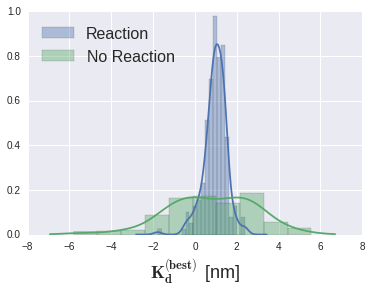

In [171]:
snr_threshold   = 2
scale_threshold = 0
nonreactive_kd  = 30000

aggregated['Reaction'] = (aggregated['Assoc SNR Max'] > snr_threshold) & \
                         (aggregated['Scale Max'] > scale_threshold)

sns.distplot(np.log10(aggregated[ aggregated['Reaction']]['Kd Best']), label =   'Reaction')
sns.distplot(np.log10(aggregated[~aggregated['Reaction']]['Kd Best']), label ='No Reaction')
plt.xlabel('$\mathbf{K_d^{(best)}}$ [nm]', fontsize = 18)
plt.legend(fontsize = 16, loc = 2)
print 'We have to impose Kd* = 30000 nM on non-reactive spots rather than use fit result.'

In [172]:
# create final Kd
aggregated['Kd Final'] = aggregated['Kd Best']
aggregated['Kd Final Lower'] = aggregated['Kd Final'] - aggregated['Kd Err']
aggregated['Kd Final Upper'] = aggregated['Kd Final'] + aggregated['Kd Err']

In [173]:
# create Filtered Kd and Kd Err
aggregated['Kd Filtered'] = aggregated['Kd Best']
aggregated['Kd Filtered Err'] = aggregated['Kd Err']

# Set Lower Bound Kd of non-reactive peptides to True, Upper Bound to False
aggregated['Lower Bound Kd'] = ~aggregated['Reaction']
aggregated.loc[~aggregated['Reaction'], 'Upper Bound Kd'] = False

# Set Kd of non-reactive peptides to detection threshold and Kd Err to zero
aggregated.loc[~aggregated['Reaction'], 'Kd Filtered'] = nonreactive_kd
aggregated.loc[~aggregated['Reaction'], 'Kd Filtered Err'] = 0


# Create Ka and Ka Err from Kd and Kd Err
aggregated['Ka Filtered']     = 1 / aggregated['Kd Filtered']
aggregated['Ka Filtered Err'] = aggregated['Ka Filtered'] * \
                               (aggregated['Kd Filtered Err'] / aggregated['Kd Filtered'])

# Set Kd Err and Ka Err of peptides with Upper or Lower Bound flag to zero
aggregated.loc[aggregated['Upper Bound Kd'], 'Kd Filtered Err'] = 0
aggregated.loc[aggregated['Upper Bound Kd'], 'Ka Filtered Err'] = 0
aggregated.loc[aggregated['Lower Bound Kd'], 'Kd Filtered Err'] = 0
aggregated.loc[aggregated['Lower Bound Kd'], 'Ka Filtered Err'] = 0    

aggregated.head()

,Peptide,Peptide Length,Peptide Weight,Number of Spots,Kd Best,Kd,Kd Err,Scale Max,Assoc SNR Max,Assoc Signal Max,Upper Bound Kd,Reaction,Kd Final,Kd Final Lower,Kd Final Upper,Kd Filtered,Kd Filtered Err,Lower Bound Kd,Ka Filtered,Ka Filtered Err
0,ATHPQFAT,8,998,3,6.603,6.603,1.8700,0.000982,5.865785,0.001085,False,True,6.603,4.7330,8.4730,6.603,1.8700,False,0.151446,0.042890
1,CTHPQFAT,8,1030,3,13.330,13.330,3.6470,0.000966,6.570487,0.001051,False,True,13.330,9.6830,16.9770,13.330,3.6470,False,0.075019,0.020525
2,DTHPQFAT,8,1042,2,4.131,4.131,1.5470,0.001098,6.878876,0.001325,False,True,4.131,2.5840,5.6780,4.131,1.5470,False,0.242072,0.090653
3,ETHPQFAT,8,1055,2,3.669,3.669,1.5310,0.001172,4.340134,0.001046,False,True,3.669,2.1380,5.2000,3.669,1.5310,False,0.272554,0.113731
4,FTHPQFAT,8,1074,2,1.286,1.286,0.7046,0.001123,7.917861,0.001299,False,True,1.286,0.5814,1.9906,1.286,0.7046,False,0.777605,0.426050


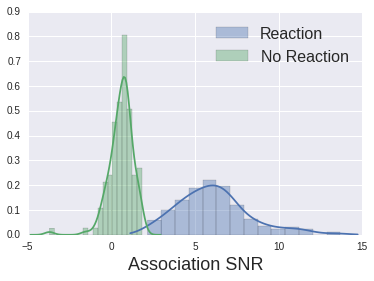

In [174]:
sns.distplot(aggregated[ aggregated['Reaction']]['Assoc SNR Max'], label =   'Reaction')
sns.distplot(aggregated[~aggregated['Reaction']]['Assoc SNR Max'], label ='No Reaction')
plt.xlabel('Association SNR', fontsize = 18)
plt.legend(fontsize = 16)

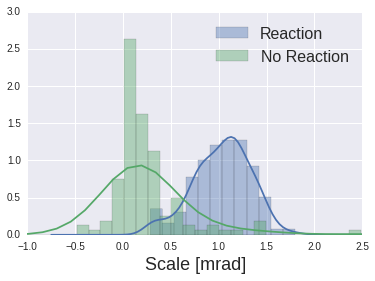

In [175]:
sns.distplot(aggregated[ aggregated['Reaction']]['Scale Max'] * 1000, label =    'Reaction')
sns.distplot(aggregated[~aggregated['Reaction']]['Scale Max'] * 1000, label = 'No Reaction', bins = 100)
plt.xlabel('Scale [mrad]', fontsize = 18)
plt.xlim(-1, 2.5)
plt.legend(fontsize = 16)

In [176]:
tmp = aggregated.groupby(['Peptide Length', 'Reaction']).agg({'Upper Bound Kd' : [len, 'sum']})
tmp.columns =  ['Number of All Kds', 'Number of Upper Bounds'] 
print 'How many reactive and non-reactive peptides of length 8 and 9 we have?'
print 'In how many cases only Upper Bound Kd is available?'
print '(Peptide is reactive, but we know only lower bound of Ka.)'
tmp

How many reactive and non-reactive peptides of length 8 and 9 we have?
In how many cases only Upper Bound Kd is available?
(Peptide is reactive, but we know only lower bound of Ka.)


Number of All Kds  Number of Upper Bounds
Peptide Length Reaction                                           
8              False                    69                       0
               True                     93                       4
9              False                    60                       0
               True                    112                       8

In [177]:
tmp = aggregated.groupby(['Peptide Length', 'Reaction']).agg({'Lower Bound Kd' : [len, 'sum']})
tmp.columns =  ['Number of All Kds', 'Number of Lower Bounds'] 
print 'How many reactive and non-reactive peptides of length 8 and 9 we have?'
print 'In how many cases only Lower Bound Kd is available?'
print '(Peptide is non-reactive, so we know only upper bound of Ka.)'
tmp

How many reactive and non-reactive peptides of length 8 and 9 we have?
In how many cases only Lower Bound Kd is available?
(Peptide is non-reactive, so we know only upper bound of Ka.)


Number of All Kds  Number of Lower Bounds
Peptide Length Reaction                                           
8              False                    69                      69
               True                     93                       0
9              False                    60                      60
               True                    112                       0

In [178]:
print 'These peptide are reactive, but their dissociation rate is below detection limit.'
print 'Reported Kd Filtered values represent upper boundaries of Kd, not actual values of Kd.\n'
print 'When plotting, we should not assign any error bars to these points,'
print 'but make them distinct from regular points with fit Kds.'
columns = ['Peptide', 'Reaction', 'Upper Bound Kd', 'Kd Filtered']
aggregated[aggregated['Reaction'] & aggregated['Upper Bound Kd']][columns]

These peptide are reactive, but their dissociation rate is below detection limit.
Reported Kd Filtered values represent upper boundaries of Kd, not actual values of Kd.

When plotting, we should not assign any error bars to these points,
but make them distinct from regular points with fit Kds.


,Peptide,Reaction,Upper Bound Kd,Kd Filtered
51,WTHDQFAT,True,True,236.20000
103,WTHPQFHT,True,True,0.38000
131,WTHPQYAT,True,True,10.39000
140,WTHSQFAT,True,True,1.13800
174,LEWHPQAGK,True,True,0.30090
179,LKWHPQAGK,True,True,0.78710
185,LQCHPQAGK,True,True,0.45470
198,LQRHPQAGK,True,True,2.93000
268,LQWHPQATK,True,True,1.31600
269,LQWHPQAVK,True,True,16.67000


In [179]:
aggregated.to_csv('04 Aggregated dR RT Streptavidin length 8 and 9.csv', index = False)

In [180]:
aggregated.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 334 entries, 0 to 333
Data columns (total 20 columns):
Peptide             334 non-null object
Peptide Length      334 non-null int64
Peptide Weight      334 non-null int64
Number of Spots     334 non-null int64
Kd Best             334 non-null float64
Kd                  334 non-null float64
Kd Err              334 non-null float64
Scale Max           334 non-null float64
Assoc SNR Max       334 non-null float64
Assoc Signal Max    334 non-null float64
Upper Bound Kd      334 non-null bool
Reaction            334 non-null bool
Kd Final            334 non-null float64
Kd Final Lower      334 non-null float64
Kd Final Upper      334 non-null float64
Kd Filtered         334 non-null float64
Kd Filtered Err     334 non-null float64
Lower Bound Kd      334 non-null bool
Ka Filtered         334 non-null float64
Ka Filtered Err     334 non-null float64
dtypes: bool(3), float64(13), int64(3), object(1)
memory usage: 47.9+ KB


In [181]:
print 'Check if any errorbars of Ka are larger than 2 on log scale.'
aggregated[aggregated['Ka Filtered'] + aggregated['Ka Filtered Err'] > 100]

Check if any errorbars of Ka are larger than 2 on log scale.


,Peptide,Peptide Length,Peptide Weight,Number of Spots,Kd Best,Kd,Kd Err,Scale Max,Assoc SNR Max,Assoc Signal Max,Upper Bound Kd,Reaction,Kd Final,Kd Final Lower,Kd Final Upper,Kd Filtered,Kd Filtered Err,Lower Bound Kd,Ka Filtered,Ka Filtered Err


In [182]:
aggregated[aggregated['Ka Filtered Err'] > aggregated['Ka Filtered']]

,Peptide,Peptide Length,Peptide Weight,Number of Spots,Kd Best,Kd,Kd Err,Scale Max,Assoc SNR Max,Assoc Signal Max,Upper Bound Kd,Reaction,Kd Final,Kd Final Lower,Kd Final Upper,Kd Filtered,Kd Filtered Err,Lower Bound Kd,Ka Filtered,Ka Filtered Err
120,WTHPQKAT,8,1094,2,100.500,100.500,113.300,0.000330,2.441405,0.000400,False,True,100.500,-12.800,213.800,100.500,113.300,False,0.009950,0.011218
224,LQWHPFAGK,9,1227,3,218.600,218.600,229.300,0.000306,2.421180,0.000266,False,True,218.600,-10.700,447.900,218.600,229.300,False,0.004575,0.004798
236,LQWHPQAEK,9,1280,1,1.844,1.844,2.271,0.000721,3.641741,0.000881,False,True,1.844,-0.427,4.115,1.844,2.271,False,0.542299,0.667875
277,LQWHPQHGK,9,1275,2,4.355,4.355,8.394,0.000380,2.755436,0.000435,False,True,4.355,-4.039,12.749,4.355,8.394,False,0.229621,0.442581
290,LQWHPQYGK,9,1301,4,22.440,68.010,35.630,0.000799,5.134123,0.001124,False,True,22.440,-13.190,58.070,22.440,35.630,False,0.044563,0.070757
